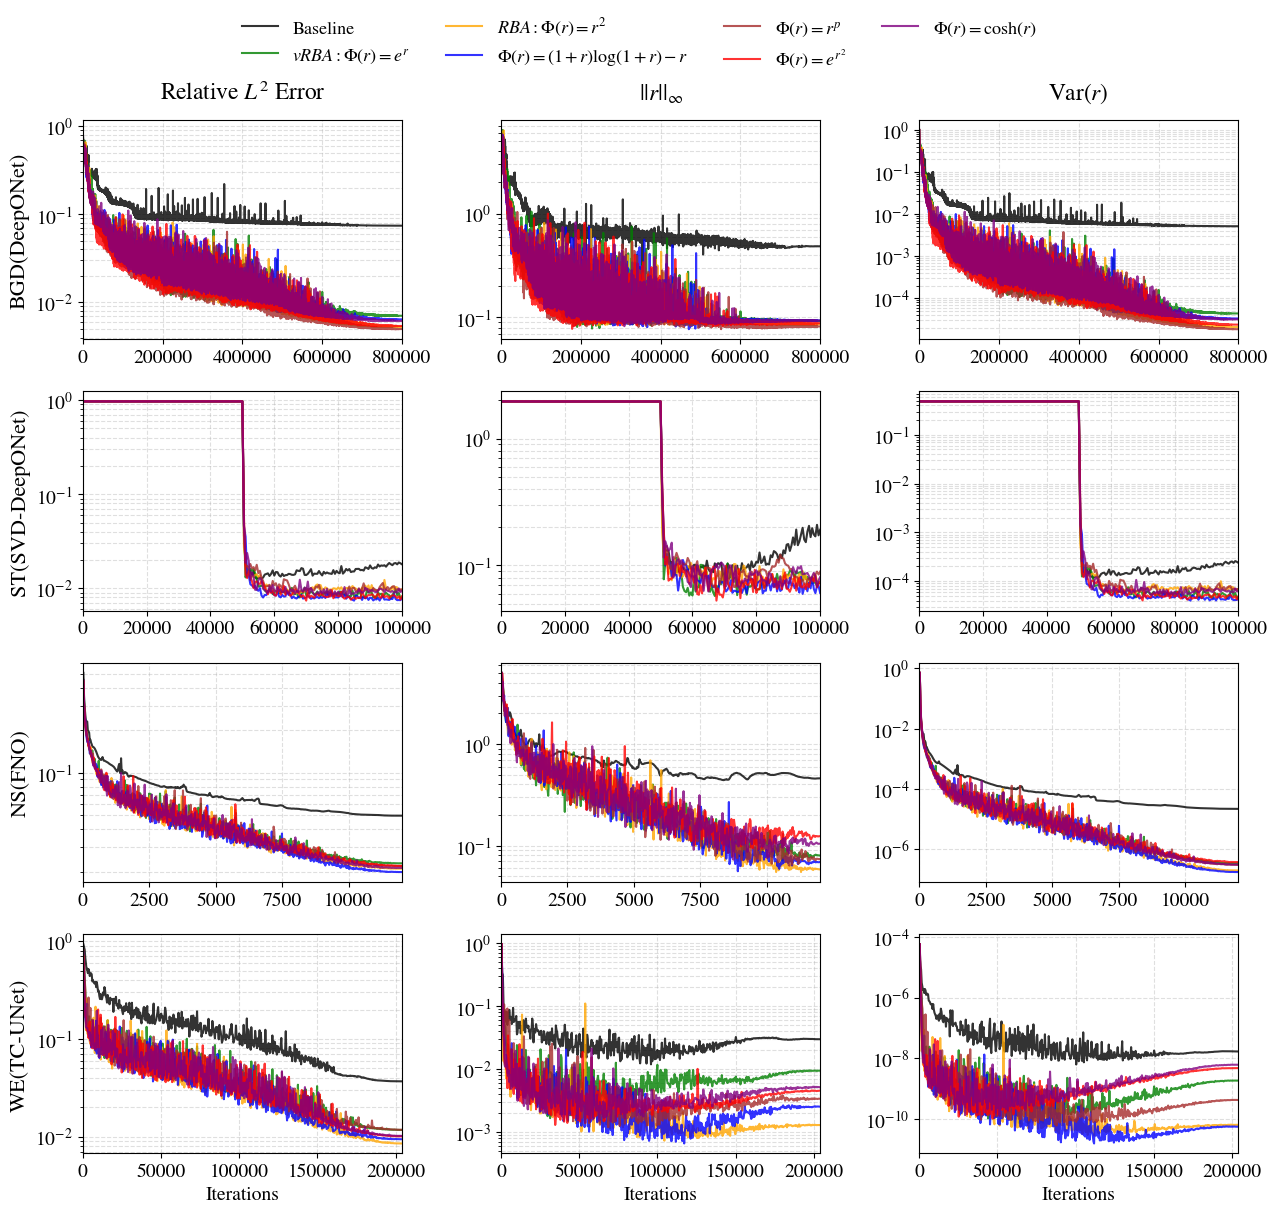

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

# --- 1. Formatting Setup ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- 2. Configuration & Styles ---
DIVERGENCE_THRESHOLD = 1e5

# Batch scalers
BATCH_SIZE_SCALER_BGD  = 80  
BATCH_SIZE_SCALER_NS   = 24
BATCH_SIZE_SCALER_WAVE = 408 

STYLES = {
    'linear':      {'label': r'Baseline',              'color': 'k'},
    'Vanilla':     {'label': r'Baseline',              'color': 'k'}, 
    'exponential': {'label': r'$vRBA: \Phi(r)=e^{r}$', 'color': 'green'},
    'quadratic':   {'label': r'$RBA: \Phi(r)=r^{2}$',  'color': 'orange'},
    'logarithmic': {'label': r'$\Phi(r)=(1+r)\log(1+r)-r$',   'color': 'blue'},
    'lp':          {'label': r'$\Phi(r)=r^{p}$',       'color': 'brown'},
    'superexp':    {'label': r'$\Phi(r)=e^{r^2}$',     'color': 'red'},
    'cosh':        {'label': r'$\Phi(r)=\cosh(r)$',    'color': 'purple'},
}

METHODS = ['linear', 'exponential', 'quadratic', 'logarithmic', 'lp', 'superexp', 'cosh']

# Paths
EXAMPLES = {
    'BGD': {
        'dir': './bubble_don/vrba_sample/results', 
        'name': 'BGD(DeepONet)',
        'type': 'DeepONet_Generic',
        'scaler': BATCH_SIZE_SCALER_BGD
    },
    'Sod': {
        'dir': './Shocks/HPR',
        'name': 'ST(SVD-DeepONet)',
        'type': 'Sod',
        'scaler': 1
    },
    'NS': {
        'dir': './ns_fno/vrba_sample/results', 
        'name': 'NS(FNO)',
        'type': 'DeepONet_Generic',
        'scaler': BATCH_SIZE_SCALER_NS
    },
    'Wave': {
        'dir': './wave_tcunet/vrba_sample/results', 
        'name': 'WE(Tc-UNet)',
        'type': 'DeepONet_Generic',
        'scaler': BATCH_SIZE_SCALER_WAVE
    }
}

ROW_ORDER = ['BGD', 'Sod', 'NS', 'Wave']

# --- 3. Data Loading Logic ---

def find_metrics_file(base_dir, method_key):
    """
    Locates metrics_*.npz file. 
    Updates: Added 'standard' and 'regular' to linear search to help find Wave baseline.
    """
    if not os.path.exists(base_dir):
        return None
        
    candidates = glob.glob(os.path.join(base_dir, "metrics_*.npz"))
    
    search_map = {
        # Broadened search for linear/baseline
        'linear':      ['vanilla', 'uniform', 'baseline', 'linear', 'standard', 'regular'],
        'Vanilla':     ['vanilla', 'uniform', 'baseline', 'standard'],
        'exponential': ['exponential', 'vrba'],
        'quadratic':   ['quadratic', 'rba'],
        'logarithmic': ['log'],
        'lp':          ['lp'],
        'superexp':    ['super'],
        'cosh':        ['cosh']
    }
    
    targets = search_map.get(method_key, [method_key])
    
    for filepath in candidates:
        fname = os.path.basename(filepath).lower()
        
        # Conflict resolution (ensure quadratic doesn't grab vrba)
        if method_key == 'quadratic' and 'vrba' in fname:
            continue
            
        for t in targets:
            if t in fname:
                return filepath
    return None

def load_history(example_key, method):
    ex_config = EXAMPLES[example_key]
    ex_type = ex_config['type']
    
    # ---------------------------
    # CASE 1: DeepONet Generic (BGD, NS, Wave)
    # ---------------------------
    if ex_type == 'DeepONet_Generic':
        filepath = find_metrics_file(ex_config['dir'], method)
        if filepath is None:
            # Debug print for missing files
            if method == 'linear':
                print(f"Warning: No baseline file found for {example_key} in {ex_config['dir']}")
            return None
            
        try:
            data = np.load(filepath)
            
            # 1. Iterations
            epochs = data['epochs']
            its = epochs * ex_config['scaler']
            
            # 2. Relative L2
            l2 = data['val_loss']
            
            # 3. Variance
            var = data['var_residual']
            
            # 4. L-Infinity
            # STRICT Check: User specified 'L_infty_residual' for NS/BGD
            linf = None
            
            # Priority List: Check strict key first, then fallbacks
            priority_keys = ['L_infty_residual', 'linf', 'val_linf', 'error_linf', 'Linf']
            
            for k in priority_keys:
                if k in data:
                    linf = data[k]
                    break
            
            return its, l2, linf, var
        except Exception as e:
            print(f"Error loading {example_key} {method}: {e}")
            return None

    # ---------------------------
    # CASE 2: Sod (Shock Tube)
    # ---------------------------
    elif ex_type == 'Sod':
        filename = f"results_summary_{method}.npz"
        path = os.path.join(ex_config['dir'], filename)
        
        if not os.path.exists(path):
            return None
            
        try:
            data = np.load(path)
            l2   = data['test_L2_real']
            linf = data['test_Linf_real']
            var  = data['test_Var_real']
            
            if 'iterations' in data:
                its = data['iterations']
            else:
                its = np.arange(len(l2)) * 100 
                
            return its, l2, linf, var
        except Exception as e:
            print(f"Error loading Sod {method}: {e}")
            return None

    return None

# --- 4. Plotting Routine ---
def create_comparison_plot():
    fig, axes = plt.subplots(len(ROW_ORDER), 3, figsize=(13, 12), sharex='row')
    
    if len(ROW_ORDER) == 1: axes = np.expand_dims(axes, axis=0)

    # Column Titles
    cols = [r'Relative $L^2$ Error', r'$||r||_\infty$', r'Var$(r)$']
    for ax, col in zip(axes[0], cols):
        ax.set_title(col, pad=15)

    for i, ex_key in enumerate(ROW_ORDER):
        row_axes = axes[i]
        example_name = EXAMPLES[ex_key]['name']
        
        # Row Label
        row_axes[0].set_ylabel(example_name, fontsize=16)

        max_iter_in_row = 100

        for method in METHODS:
            if method not in STYLES: continue
            
            res = load_history(ex_key, method)
            if res is None: continue
            
            its, l2, linf, var = res
            style = STYLES[method]

            if len(its) > 0:
                max_iter_in_row = max(max_iter_in_row, its[-1])

            # --- PLOTTING HELPER ---
            def plot_metric(ax, x, y):
                if y is None or len(y) == 0: return
                y_masked = y.copy()
                y_masked[y_masked > DIVERGENCE_THRESHOLD] = np.nan
                ax.plot(x, y_masked, label=style['label'], 
                        color=style['color'], linewidth=1.5, alpha=0.8)

            plot_metric(row_axes[0], its, l2)
            plot_metric(row_axes[1], its, linf)
            plot_metric(row_axes[2], its, var)

        # Formatting per row
        for ax in row_axes:
            ax.set_yscale('log')
            ax.grid(True, which="both", ls="--", alpha=0.4)
            ax.set_xlim(left=0, right=max_iter_in_row)

    # X Labels
    for ax in axes[-1]:
        ax.set_xlabel('Iterations')

    # Legend
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
               ncol=4, frameon=False, fontsize=13)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92) 
    plt.savefig('Convergence_Operator_Comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    create_comparison_plot()

In [1]:
import numpy as np
import os
import glob

# --- Configuration ---
BATCH_SIZE_SCALER_BGD  = 80  
BATCH_SIZE_SCALER_NS   = 24
BATCH_SIZE_SCALER_WAVE = 408 

# LaTeX Labels for Potentials
LATEX_LABELS = {
    'linear':      r'Baseline ($\Phi(r)=r$)',
    'Vanilla':     r'Baseline ($\Phi(r)=r$)',
    'exponential': r'$\Phi(r)=e^{r}$',
    'quadratic':   r'$\Phi(r)=r^{2}$',
    'logarithmic': r'$\Phi(r)=(1+r)\log(1+r)-r$',
    'lp':          r'$\Phi(r)=r^{p}$',
    'superexp':    r'$\Phi(r)=e^{r^2}$',
    'cosh':        r'$\Phi(r)=\cosh(r)$',
}

# Order of methods
METHODS_ORDER = ['linear', 'exponential', 'quadratic', 'logarithmic', 'lp', 'superexp', 'cosh']

# Problem Definitions
EXAMPLES = {
    'BGD':  {'dir': './bubble_don/vrba_sample/results', 'name': 'BGD (DeepONet)', 'type': 'Generic'},
    'Sod':  {'dir': './Shocks/HPR',                     'name': 'ST (SVD-DeepONet)', 'type': 'Sod'},
    'NS':   {'dir': './ns_fno/vrba_sample/results',     'name': 'NS (FNO)',  'type': 'Generic'},
    'Wave': {'dir': './wave_tcunet/vrba_sample/results','name': 'WE (Tc-UNet)',  'type': 'Generic'}
}

ROW_ORDER = ['BGD', 'Sod', 'NS', 'Wave']

# --- Helper: Find File ---
def find_metrics_file(base_dir, method_key):
    if not os.path.exists(base_dir): return None
    candidates = glob.glob(os.path.join(base_dir, "metrics_*.npz"))
    
    search_map = {
        'linear':      ['vanilla', 'uniform', 'baseline', 'linear', 'standard', 'regular'],
        'exponential': ['exponential', 'vrba'],
        'quadratic':   ['quadratic', 'rba'],
        'logarithmic': ['log'],
        'lp':          ['lp'],
        'superexp':    ['super'],
        'cosh':        ['cosh']
    }
    targets = search_map.get(method_key, [method_key])
    
    for filepath in candidates:
        fname = os.path.basename(filepath).lower()
        if method_key == 'quadratic' and 'vrba' in fname: continue
        for t in targets:
            if t in fname: return filepath
    return None

# --- Helper: Load Final Data ---
def get_final_values(ex_key, method):
    config = EXAMPLES[ex_key]
    
    if config['type'] == 'Generic':
        fpath = find_metrics_file(config['dir'], method)
        if not fpath: return None
        try:
            d = np.load(fpath)
            l2 = d['val_loss'][-1]
            var = d['var_residual'][-1]
            linf = np.nan
            for k in ['L_infty_residual', 'linf', 'val_linf', 'Linf', 'error_linf']:
                if k in d:
                    linf = d[k][-1]
                    break
            return l2, linf, var
        except: return None
        
    elif config['type'] == 'Sod':
        fpath = os.path.join(config['dir'], f"results_summary_{method}.npz")
        if not os.path.exists(fpath): return None
        try:
            d = np.load(fpath)
            return d['test_L2_real'][-1], d['test_Linf_real'][-1], d['test_Var_real'][-1]
        except: return None
    return None

# --- Helper: Format Scientific Notation ---
def fmt_sci(val):
    if val is None or np.isnan(val): return "-"
    # Format as 1.23 x 10^{-4}
    exponent = int(np.floor(np.log10(abs(val))))
    mantissa = val / (10**exponent)
    return f"${mantissa:.2f}\\times10^{{{exponent}}}$"

# --- Main: Generate LaTeX ---
def print_latex_table():
    print(r"\begin{table}[h]")
    print(r"\caption{Performance of the vRBA framework across PINN and operator-learning benchmarks. We report the best achieved relative $L^2$ Error and the residual variance and maximum (i.e., $\mathrm{Var}(r)$  $\|r\|_\infty)$. Parameter counts are fixed per benchmark. Runtimes are approximate and vRBA incurs $<10\%$ overhead.}")
    print(r"\label{tab:all_results}")
    print(r"\begin{tabular*}{\textwidth}{@{\extracolsep{\fill}}llccc}")
    print(r"\toprule")
    print(r"\textbf{Problem} & \textbf{Method} & Relative\ $L^2$ & $\mathrm{Var}(r)$ & $\|r\|_\infty$ \\")
    
    for ex_key in ROW_ORDER:
        print(r"\midrule")
        ex_name = EXAMPLES[ex_key]['name']
        
        first_row = True
        
        for method in METHODS_ORDER:
            vals = get_final_values(ex_key, method)
            
            # Problem Name: Only on first row, else empty string
            prob_str = ex_name if first_row else ""
            
            # Method Label
            method_str = LATEX_LABELS.get(method, method)
            
            if vals:
                l2, linf, var = vals
                
                # Check for "Best" (Visual bolding logic could be added here, 
                # but standard formatted printing for now)
                
                print(f"{prob_str} & {method_str} & {fmt_sci(l2)} & {fmt_sci(var)} & {fmt_sci(linf)} \\\\")
            else:
                # print(f"{prob_str} & {method_str} & - & - & - \\\\") # Uncomment to show missing
                pass
            
            first_row = False

    print(r"\bottomrule")
    print(r"\end{tabular*}")
    print(r"\end{table}")

if __name__ == "__main__":
    print_latex_table()

\begin{table}[h]
\caption{Performance of the vRBA framework across PINN and operator-learning benchmarks. We report the best achieved relative $L^2$ Error and the residual variance and maximum (i.e., $\mathrm{Var}(r)$  $\|r\|_\infty)$. Parameter counts are fixed per benchmark. Runtimes are approximate and vRBA incurs $<10\%$ overhead.}
\label{tab:all_results}
\begin{tabular*}{\textwidth}{@{\extracolsep{\fill}}llccc}
\toprule
\textbf{Problem} & \textbf{Method} & Relative\ $L^2$ & $\mathrm{Var}(r)$ & $\|r\|_\infty$ \\
\midrule
BGD (DeepONet) & Baseline ($\Phi(r)=r$) & $7.41\times10^{-2}$ & $5.15\times10^{-3}$ & $4.84\times10^{-1}$ \\
 & $\Phi(r)=e^{r}$ & $5.16\times10^{-3}$ & $1.94\times10^{-5}$ & $8.22\times10^{-2}$ \\
 & $\Phi(r)=r^{2}$ & $5.72\times10^{-3}$ & $2.43\times10^{-5}$ & $8.60\times10^{-2}$ \\
 & $\Phi(r)=(1+r)\log(1+r)-r$ & $5.73\times10^{-3}$ & $2.64\times10^{-5}$ & $9.16\times10^{-2}$ \\
 & $\Phi(r)=r^{p}$ & $9.09\times10^{-3}$ & $6.34\times10^{-5}$ & $9.54\times10^{-2}$ 

--- Loading BGD DEEPONET Data ---
  ✓ BGD data loaded.
--- Loading SHOCK TUBE Data ---
  ✓ Best ST model identified: logarithmic
Figure saved: comparison_final_ordered.png


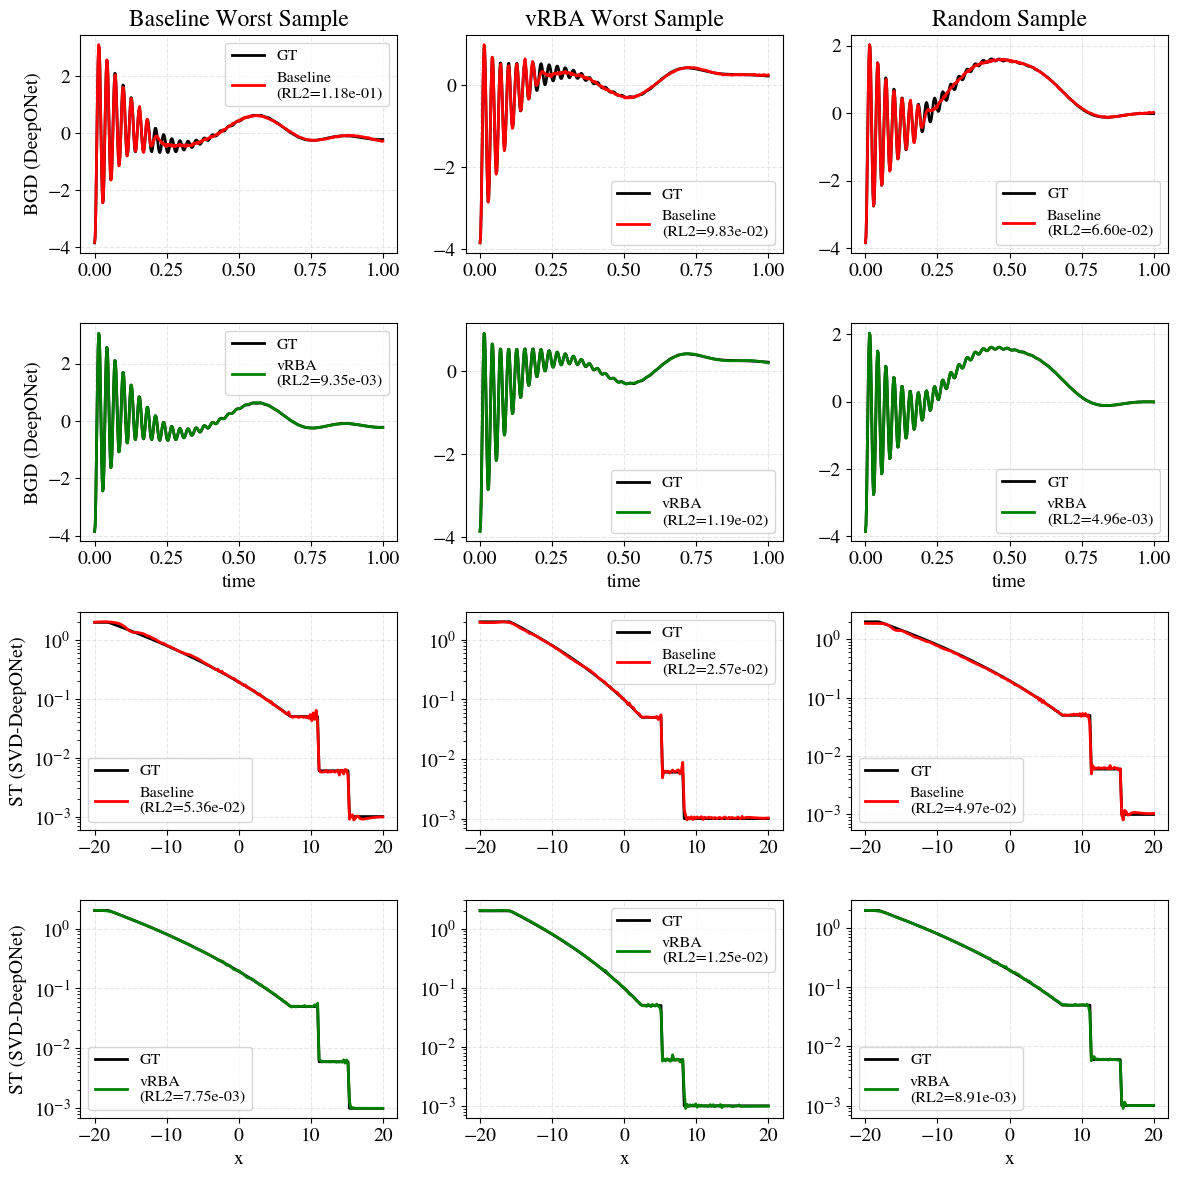

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os

# --- Global Style Settings ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# ==========================================
# 1. LOAD BGD DEEPONET DATA (Rows 0 & 1)
# ==========================================
print("--- Loading BGD DEEPONET Data ---")
bgd_dir = "/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/bubble_don"

bgd_paths = {
    'time': os.path.join(bgd_dir, "vanilla/time.npy"),
    'true': os.path.join(bgd_dir, "vanilla/Y_TRUE.npy"),
    'baseline': os.path.join(bgd_dir, "vanilla/Y_PRED.npy"),
    'competitor': os.path.join(bgd_dir, "vrba_sample/Y_PRED.npy") 
}

bgd_data = {}
try:
    bgd_time = np.load(bgd_paths['time'])
    bgd_true = np.load(bgd_paths['true'])
    bgd_data['Baseline'] = np.load(bgd_paths['baseline'])
    bgd_data['Lp'] = np.load(bgd_paths['competitor'])
    print("  ✓ BGD data loaded.")
except FileNotFoundError as e:
    print(f"CRITICAL ERROR: {e}")
    sys.exit()

# BGD Metrics & Selection
def get_l2_vector(true, pred):
    errs = []
    for i in range(true.shape[0]):
        n_t = np.linalg.norm(true[i])
        n_e = np.linalg.norm(true[i] - pred[i])
        errs.append(n_e / n_t if n_t > 0 else 0)
    return np.array(errs)

bgd_err_base = get_l2_vector(bgd_true, bgd_data['Baseline'])
bgd_err_comp = get_l2_vector(bgd_true, bgd_data['Lp'])

# Indices
idx_bgd_worst_base = np.argmax(bgd_err_base)
sorted_bgd_comp = np.argsort(bgd_err_comp)[::-1]
idx_bgd_worst_comp = sorted_bgd_comp[0]
if idx_bgd_worst_comp == idx_bgd_worst_base: idx_bgd_worst_comp = sorted_bgd_comp[1]

valid_bgd = list(set(range(len(bgd_true))) - {idx_bgd_worst_base, idx_bgd_worst_comp})
idx_bgd_random = np.random.choice(valid_bgd)

bgd_indices = [idx_bgd_worst_base, idx_bgd_worst_comp, idx_bgd_random]

# ==========================================
# 2. LOAD SHOCK TUBE DATA (Rows 2 & 3)
# ==========================================
print("--- Loading SHOCK TUBE Data ---")
st_dir = "/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/Shocks/HPR"

st_config = {
    'linear':      {'label': 'Baseline', 'color': 'k',      'file': 'results_summary_linear.npz'},
    'exponential': {'label': 'vRBA',     'color': 'green',  'file': 'results_summary_exponential.npz'},
    'quadratic':   {'label': 'RBA',      'color': 'orange', 'file': 'results_summary_quadratic.npz'},
    'logarithmic': {'label': 'Log',      'color': 'blue',   'file': 'results_summary_logarithmic.npz'},
    'lp':          {'label': 'Lp',       'color': 'brown',  'file': 'results_summary_lp.npz'},
    'superexp':    {'label': 'SuperExp', 'color': 'red',    'file': 'results_summary_superexp.npz'},
    'cosh':        {'label': 'Cosh',     'color': 'purple', 'file': 'results_summary_cosh.npz'}
}

st_data = {}
for k, cfg in st_config.items():
    p = os.path.join(st_dir, cfg['file'])
    if os.path.exists(p): st_data[k] = np.load(p)

if not st_data:
    print("CRITICAL ERROR: No Shock Tube data found.")
    sys.exit()

# ST Identification
st_stats = {}
st_best_key = None
st_min_l2 = float('inf')

for k, d in st_data.items():
    l2 = get_l2_vector(d['S_true'], d['S_pred'])
    st_stats[k] = l2
    m_l2 = np.mean(l2)
    if k != 'linear' and m_l2 < st_min_l2:
        st_min_l2 = m_l2
        st_best_key = k

if st_best_key is None: st_best_key = list(st_data.keys())[0]
print(f"  ✓ Best ST model identified: {st_best_key}")

# ST Indices
st_err_base = st_stats['linear']
st_err_comp = st_stats[st_best_key]

idx_st_worst_base = np.argmax(st_err_base)
sorted_st_comp = np.argsort(st_err_comp)[::-1]
idx_st_worst_comp = sorted_st_comp[0]
if idx_st_worst_comp == idx_st_worst_base: idx_st_worst_comp = sorted_st_comp[1]

valid_st = list(set(range(len(st_err_base))) - {idx_st_worst_base, idx_st_worst_comp})
idx_st_random = np.random.choice(valid_st)

st_indices = [idx_st_worst_base, idx_st_worst_comp, idx_st_random]

# ==========================================
# 3. PLOTTING (Strict 4 Rows)
# ==========================================
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

# Column Titles (Applied only to Row 0)
col_titles = ["Baseline Worst Sample", "vRBA Worst Sample", "Random Sample"]

# Row Configs
# Structure: (Row Index, Type, ModelKey, Label, Color, X_Data, Indices, TrueData, PredDataDict, ErrorDict, IsLog)
row_configs = [
    # Row 0: BGD Baseline
    (0, "BGD", "Baseline", "Baseline", "red", bgd_time, bgd_indices, bgd_true, bgd_data, bgd_err_base, False),
    # Row 1: BGD vRBA
    (1, "BGD", "Lp", "vRBA", "green", bgd_time, bgd_indices, bgd_true, bgd_data, bgd_err_comp, False),
    # Row 2: ST Baseline
    (2, "ST", "linear", "Baseline", "red", st_data['linear']['x_spatial'], st_indices, st_data['linear']['S_true'], {k:v['S_pred'] for k,v in st_data.items()}, st_err_base, True),
    # Row 3: ST Best
    (3, "ST", st_best_key, "vRBA", "green", st_data['linear']['x_spatial'], st_indices, st_data[st_best_key]['S_true'], {k:v['S_pred'] for k,v in st_data.items()}, st_err_comp, True)
]

for r_idx, r_type, m_key, y_label_text, color, x_vals, indices, true_full, pred_dict, err_vec, is_log in row_configs:
    
    for c_idx, s_idx in enumerate(indices):
        ax = axes[r_idx, c_idx]
        
        # Data
        if r_type == "ST":
            # For ST, true data might differ per file slightly if grids changed, usually consistent
            # We use the specific model's true/pred to be safe or linear's true
             y_t = true_full[s_idx]
             y_p = pred_dict[m_key][s_idx]
             # For ST indices are from linear/best stats, need to be careful if arrays match size
             # Assuming standard consistent dataset size
        else:
            y_t = true_full[s_idx]
            y_p = pred_dict[m_key][s_idx]
            
        # Error for Legend
        if r_type == "ST":
            rl2 = st_stats[m_key][s_idx]
        else:
            # Recompute locally or use precomputed vector
            n_t = np.linalg.norm(y_t)
            n_e = np.linalg.norm(y_t - y_p)
            rl2 = n_e / n_t if n_t > 0 else 0

        # Plot
        ax.plot(x_vals, y_t, 'k-', lw=2, label='GT')
        ax.plot(x_vals, y_p, color=color, lw=2, label=f"{y_label_text}\n(RL2={rl2:.2e})")
        
        # Scaling
        if is_log:
            ax.set_yscale('log')
        
        # Titles (Only Top Row)
        if r_idx == 0:
            ax.set_title(col_titles[c_idx])
        if r_idx==1:
            ax.set_xlabel('time')
        if r_idx==3:
            ax.set_xlabel('x')     
        # Y Labels (Row Identifiers on First Column)
        if (r_idx == 0 or  r_idx ==1) and c_idx==0:
            ax.set_ylabel('BGD (DeepONet)')
        elif (r_idx == 2 or r_idx==3 )and c_idx==0 :
            ax.set_ylabel('ST (SVD-DeepONet)')
        # Legend (Contains RL2 error now)
        ax.legend(fontsize=11.5, loc='best', frameon=True)
        ax.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_DeepONet.png', dpi=300)
print("Figure saved: comparison_final_ordered.png")
plt.show()

Loading: /users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/ns_fno
Loading: /users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/wave_tcunet
Figure saved to: combined_snapshots_final_labels.png


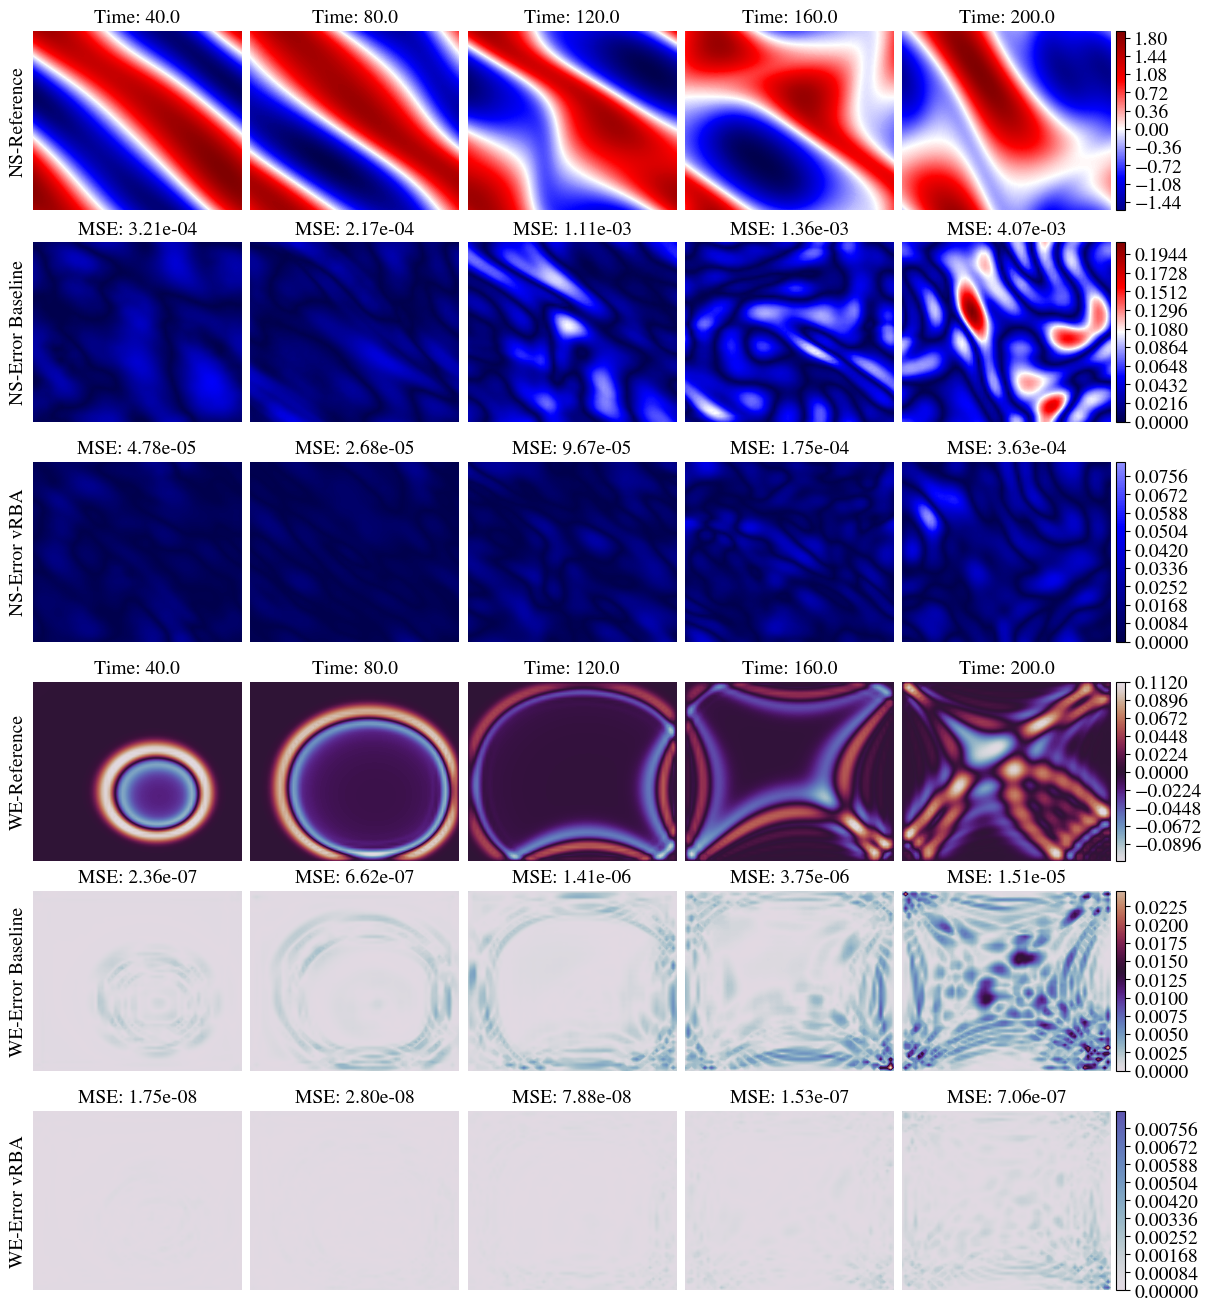

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import os

# --- Global Style Settings ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- Helper Functions ---
def mse_metric(a, b):
    return np.mean(np.abs(a - b)**2)

def load_dataset(base_dir, sample_id=0, skip_t=10):
    """
    Loads True, Baseline Pred, and RBA Pred for a given directory.
    """
    # Try lowercase first, then capitalized 'Vanilla' if needed
    p_true = os.path.join(base_dir, "vanilla/Y_TRUE.npy")
    p_base = os.path.join(base_dir, "vanilla/Y_PRED.npy")
    
    if not os.path.exists(p_true):
        p_true = os.path.join(base_dir, "Vanilla/Y_TRUE.npy")
        p_base = os.path.join(base_dir, "Vanilla/Y_PRED.npy")
        
    p_rba = os.path.join(base_dir, "vrba_sample/Y_PRED.npy")

    try:
        print(f"Loading: {base_dir}")
        Y_TRUE = np.load(p_true)
        Y_BASE = np.load(p_base)
        Y_RBA = np.load(p_rba)
        
        # Time array: 0 to 200, 51 steps
        t_ls = np.linspace(0, 200, 51)
        
        # Slicing: Skip 10, discard first (indices 10, 20, 30, 40, 50)
        true_slice = Y_TRUE[sample_id, ::skip_t][1:]
        base_slice = Y_BASE[sample_id, ::skip_t][1:]
        rba_slice = Y_RBA[sample_id, ::skip_t][1:]
        time_slice = t_ls[::skip_t][1:]
        
        return true_slice, base_slice, rba_slice, time_slice

    except FileNotFoundError as e:
        print(f"CRITICAL ERROR: {e}")
        sys.exit()

# --- 1. Load Data ---

# Path 1: Navier-Stokes (NS) - FNO
dir_ns = "/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/ns_fno"
ns_data = load_dataset(dir_ns)

# Path 2: Wave Equation (WE) - TC-UNet
dir_wave = "/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/wave_tcunet"
we_data = load_dataset(dir_wave)

# --- 2. Plotting Configuration ---

fig, axes = plt.subplots(6, 5, figsize=(12, 13), constrained_layout=True)

# Define configurations for the two sections
# Format: (StartRow, DataTuple, Colormap, RowLabels)
sections = [
    {
        'start_row': 0,
        'data': ns_data,
        'cmap': 'seismic',
        'labels': ["NS-Reference", "NS-Error Baseline", "NS-Error vRBA"]
    },
    {
        'start_row': 3,
        'data': we_data,
        'cmap': 'twilight',
        'labels': ["WE-Reference", "WE-Error Baseline", "WE-Error vRBA"]
    }
]

for section in sections:
    start = section['start_row']
    true, base, rba, times = section['data']
    cmap = section['cmap']
    labels = section['labels']
    
    # Calculate global error bounds based on Baseline (to allow comparison)
    err_base_full = np.abs(base - true)
    err_rba_full = np.abs(rba - true)
    
    vmin_err = np.min(err_base_full)
    vmax_err = np.max(err_base_full)

    # Loop columns (Time steps)
    for i in range(5):
        # --- Row 0 of section: Reference (Ground Truth) ---
        ax0 = axes[start, i]
        vm_gt = np.max(np.abs(true[i]))
        im0 = ax0.contourf(true[i], 300, vmin=-vm_gt, vmax=vm_gt, cmap=cmap)
        ax0.set_title(f'Time: {times[i]:.1f}', fontsize=14)
        
        # --- Row 1 of section: Baseline Error ---
        ax1 = axes[start + 1, i]
        im1 = ax1.contourf(err_base_full[i], 300, vmin=vmin_err, vmax=vmax_err, cmap=cmap)
        mse1 = mse_metric(true[i], base[i])
        ax1.set_title(f'MSE: {mse1:.2e}', fontsize=14)
        
        # --- Row 2 of section: vRBA Error ---
        ax2 = axes[start + 2, i]
        im2 = ax2.contourf(err_rba_full[i], 300, vmin=vmin_err, vmax=vmax_err, cmap=cmap)
        mse2 = mse_metric(true[i], rba[i])
        ax2.set_title(f'MSE: {mse2:.2e}', fontsize=14)
        
        # --- Formatting & Labels ---
        # We process ax0, ax1, ax2
        current_rows = [ax0, ax1, ax2]
        current_ims = [im0, im1, im2]
        
        for r_idx, ax in enumerate(current_rows):
            # Clean axis content
            ax.set_xticks([])
            ax.set_yticks([])
            
            # Remove spines (box) for cleaner look
            for spine in ax.spines.values():
                spine.set_visible(False)
            
            # Add Y-Label ONLY on the first column
            if i == 0:
                ax.set_ylabel(labels[r_idx], fontsize=14)
            
            # Add Colorbar ONLY on the last column
            if i == 4:
                cbar = plt.colorbar(current_ims[r_idx], ax=ax, fraction=0.046, pad=0.02)
                cbar.ax.tick_params(labelsize=14)

# Save
out_path = 'combined_snapshots_final_labels.png'
plt.savefig(out_path, dpi=300)
print(f"Figure saved to: {out_path}")
plt.show()

Loading: /users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/ns_fno
Loading: /users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/wave_tcunet
Figure saved to: Error_Metrics_Combined_2Rows.png


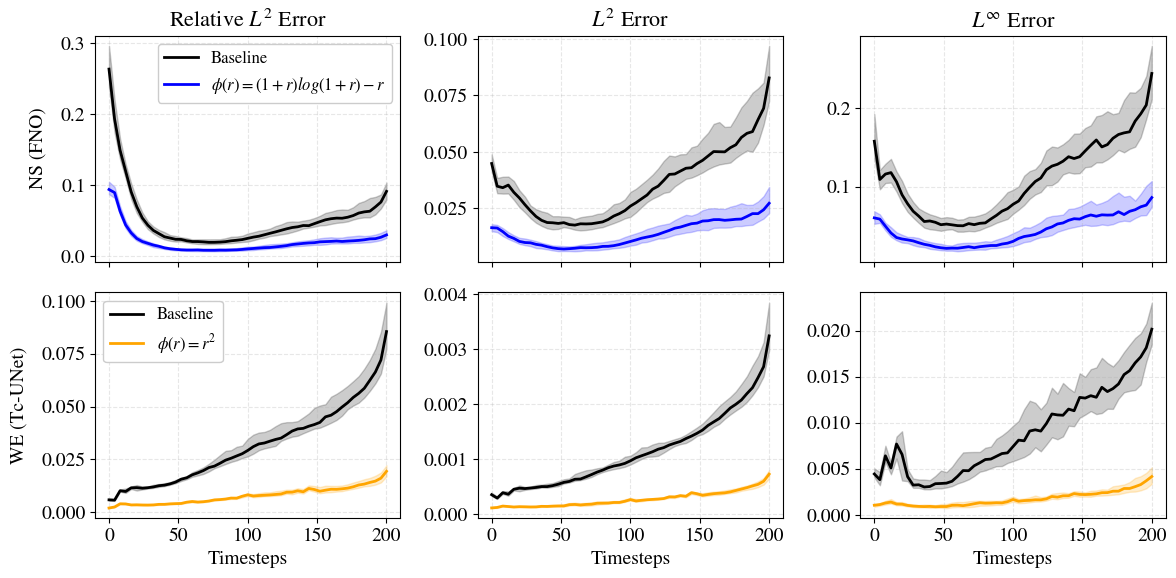

In [107]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.linalg import norm
import sys
import os

# --- Global Style Settings ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- Helper: Data Loading ---
def load_data(base_dir):
    """Loads TRUE, PRED (Baseline), and PRED_RBA from standard paths."""
    p_true = os.path.join(base_dir, "vanilla/Y_TRUE.npy")
    p_base = os.path.join(base_dir, "vanilla/Y_PRED.npy")
    
    # Fallback for capitalization
    if not os.path.exists(p_true):
        p_true = os.path.join(base_dir, "Vanilla/Y_TRUE.npy")
        p_base = os.path.join(base_dir, "Vanilla/Y_PRED.npy")
        
    p_rba = os.path.join(base_dir, "vrba_sample/Y_PRED.npy")

    try:
        print(f"Loading: {base_dir}")
        Y_TRUE = np.load(p_true)
        Y_BASE = np.load(p_base)
        Y_RBA = np.load(p_rba)
        return Y_TRUE, Y_BASE, Y_RBA
    except FileNotFoundError as e:
        print(f"CRITICAL ERROR: {e}")
        sys.exit()

# --- Helper: Metric Computation ---
def compute_stats(TRUE, PRED, PRED_rba):
    # Flatten: (Samples, Time, Space) -> (Samples, Time, Features)
    TRUE_flat = TRUE.reshape(TRUE.shape[0], TRUE.shape[1], -1)
    PRED_flat = PRED.reshape(PRED.shape[0], PRED.shape[1], -1)
    PRED_rba_flat = PRED_rba.reshape(PRED_rba.shape[0], PRED_rba.shape[1], -1)
    
    # 1. Relative L2 Error
    # Shape: (Samples, Time)
    err = np.zeros((TRUE.shape[0], TRUE.shape[1]))
    err_rba = np.zeros((TRUE.shape[0], TRUE.shape[1]))
    
    for i in range(TRUE.shape[0]):
        for j in range(TRUE.shape[1]):
            n_t = norm(TRUE_flat[i, j])
            if n_t != 0:
                err[i, j] = norm(PRED_flat[i, j] - TRUE_flat[i, j]) / n_t
                err_rba[i, j] = norm(PRED_rba_flat[i, j] - TRUE_flat[i, j]) / n_t

    # 2. Absolute L2 (RMSE)
    l2_abs = np.sqrt(np.mean((PRED_flat - TRUE_flat)**2, axis=2))
    l2_abs_rba = np.sqrt(np.mean((PRED_rba_flat - TRUE_flat)**2, axis=2))
    
    # 3. L-infinity
    linf_abs = np.max(np.abs(PRED_flat - TRUE_flat), axis=2)
    linf_abs_rba = np.max(np.abs(PRED_rba_flat - TRUE_flat), axis=2)
    
    # Compute Percentiles (25, 50, 75)
    def get_perc(arr):
        return np.percentile(arr, 50, axis=0), np.percentile(arr, 25, axis=0), np.percentile(arr, 75, axis=0)

    stats = {
        'rel_l2': (get_perc(err), get_perc(err_rba)),
        'abs_l2': (get_perc(l2_abs), get_perc(l2_abs_rba)),
        'linf':   (get_perc(linf_abs), get_perc(linf_abs_rba)),
        'timesteps': np.linspace(0, 200, TRUE.shape[1])
    }
    return stats

# --- 1. Load & Process Data ---
dir_ns = "/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/ns_fno"
ns_stats = compute_stats(*load_data(dir_ns))

dir_we = "/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning/wave_tcunet"
we_stats = compute_stats(*load_data(dir_we))

# --- 2. Plotting ---
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True)

# Configuration for rows
rows_config = [
    (0, ns_stats, 'blue', "NS (FNO)"),
    (1, we_stats, 'orange', "WE (Tc-UNet)")
]

# Column definitions
metric_keys = ['rel_l2', 'abs_l2', 'linf']
titles = [r'Relative $L^2$ Error', r'$L^2$ Error', r'$L^\infty$ Error']

for row_idx, stats, rba_color, row_label in rows_config:
    timesteps = stats['timesteps']
    
    for col_idx, m_key in enumerate(metric_keys):
        ax = axes[row_idx, col_idx]
        
        # Unpack metrics
        (base_p50, base_p25, base_p75), (rba_p50, rba_p25, rba_p75) = stats[m_key]
        
        # Plot Baseline (Red)
        ax.plot(timesteps, base_p50, color='black', label='Baseline', lw=2)
        ax.fill_between(timesteps, base_p25, base_p75, color='black', alpha=0.2)
        
        # Plot vRBA (Green/Orange)
        if row_idx == 0:
            ax.plot(timesteps, rba_p50, color=rba_color, label='$\phi(r)=(1+r)log(1+r)-r$', lw=2)
        if row_idx == 1:
            ax.plot(timesteps, rba_p50, color=rba_color, label='$\phi(r)=r^2$', lw=2)
        ax.fill_between(timesteps, rba_p25, rba_p75, color=rba_color, alpha=0.2)
        
        # Formatting
        if row_idx == 0:
            ax.set_title(titles[col_idx], fontsize=16)
            
        if row_idx == 1:
            ax.set_xlabel('Timesteps', fontsize=14)
            
        if col_idx == 0: 
            
            ax.set_ylabel(row_label, fontsize=14, labelpad=10)
            # Legend only on first column of each row
            ax.legend(fontsize=12, framealpha=1, loc='best')

        ax.grid(True, which="both", ls="--", alpha=0.3)

plt.tight_layout()
out_file = 'Error_Metrics_Combined_2Rows.png'
plt.savefig(out_file, dpi=300)
print(f"Figure saved to: {out_file}")
plt.show()

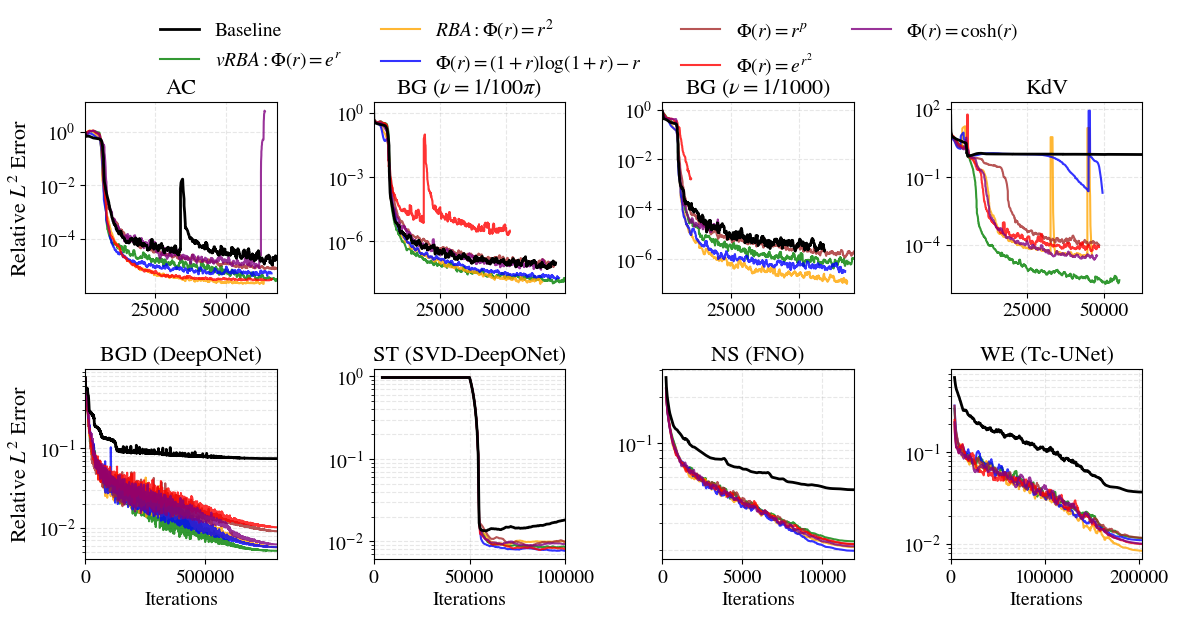

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

# --- 1. Formatting Setup ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- 2. Configuration & Styles ---
EPOCHS_ADAM = 5000  
DIVERGENCE_THRESHOLD = 1e999 
OP_DIVERGENCE_THRESHOLD = 1e5
SMOOTHING_WINDOW = 10

STYLES = {
    'linear':      {'label': r'Baseline',              'color': 'k'},
    'Vanilla':     {'label': r'Baseline',              'color': 'k'}, 
    'exponential': {'label': r'$vRBA: \Phi(r)=e^{r}$', 'color': 'green'},
    'quadratic':   {'label': r'$RBA: \Phi(r)=r^{2}$',  'color': 'orange'},
    'logarithmic': {'label': r'$\Phi(r)=(1+r)\log(1+r)-r$',   'color': 'blue'},
    'lp':          {'label': r'$\Phi(r)=r^{p}$',       'color': 'brown'},
    'superexp':    {'label': r'$\Phi(r)=e^{r^2}$',     'color': 'red'},
    'cosh':        {'label': r'$\Phi(r)=\cosh(r)$',    'color': 'purple'},
}

# Original list (defines Legend order)
METHODS = ['linear', 'exponential', 'quadratic', 'logarithmic', 'lp', 'superexp', 'cosh']

# Plot list (linear last to be on top)
PLOT_ORDER = [m for m in METHODS if m != 'linear'] + ['linear']

# --- 3. Path Configuration ---
BASE_PINN = '/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/PINN/Potential_analysis'
BASE_OP   = '/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning'

PINN_CONFIG = {
    'AC':       {'dir': 'AC',       'file_fmt': 'results_{}.npz',       'name': 'AC'},
    'BG_100pi': {'dir': 'BG_100pi', 'file_fmt': 'burgers_pred_{}.npz',  'name': r'BG ($\nu=1/100\pi$)'},
    'BG_1000':  {'dir': 'BG_1000',  'file_fmt': 'burgers_pred_{}.npz',  'name': r'BG ($\nu=1/1000$)'},
    'KdV':      {'dir': 'KdV',      'file_fmt': 'kdv_results_{}.npz',   'name': 'KdV'},
}

OP_CONFIG = {
    'BGD': {
        'path': os.path.join(BASE_OP, 'bubble_don/vrba_sample/results'), 
        'name': 'BGD (DeepONet)', 
        'type': 'DeepONet', 
        'scaler': 80
    },
    'Sod': {
        'path': os.path.join(BASE_OP, 'Shocks/HPR'),                     
        'name': 'ST (SVD-DeepONet)',
        'type': 'Sod',      
        'scaler': 1
    },
    'NS': {
        'path': os.path.join(BASE_OP, 'ns_fno/vrba_sample/results'),     
        'name': 'NS (FNO)',         
        'type': 'DeepONet', 
        'scaler': 24
    },
    'Wave': {
        'path': os.path.join(BASE_OP, 'wave_tcunet/vrba_sample/results'), 
        'name': 'WE (Tc-UNet)',      
        'type': 'DeepONet', 
        'scaler': 408
    }
}

ROW_1_KEYS = ['AC', 'BG_100pi', 'BG_1000', 'KdV']
ROW_2_KEYS = ['BGD', 'Sod', 'NS', 'Wave']

# --- 4. Helpers: Loading ---
def load_pinn_l2(example_key, method):
    ex_config = PINN_CONFIG[example_key]
    path = os.path.join(BASE_PINN, ex_config['dir'], ex_config['file_fmt'].format(method))
    
    if not os.path.exists(path):
        return None, None

    try:
        data = np.load(path)
        keys = list(data.keys())
        iter_l2, l2 = None, None

        if example_key == 'BG_1000':
            l2 = data['error_history'] if 'error_history' in keys else None
            if 'all_its' in keys: iter_l2 = data['all_its']
            elif l2 is not None: iter_l2 = np.arange(len(l2))
        elif example_key == 'KdV':
            l2 = data['relative_l2_history'] if 'relative_l2_history' in keys else None
            iter_l2 = data['iterations'] if 'iterations' in keys else None
            if iter_l2 is None and l2 is not None: iter_l2 = np.arange(len(l2))
        else: 
            l2 = data['error_history'] if 'error_history' in keys else None
            iter_l2 = data['all_its'] if 'all_its' in keys else None
            if iter_l2 is None and l2 is not None: iter_l2 = np.arange(len(l2))

        return iter_l2, l2
    except Exception as e:
        print(f"Error PINN {example_key}/{method}: {e}")
        return None, None

def find_metrics_file(base_dir, method_key):
    if not os.path.exists(base_dir): return None
    candidates = glob.glob(os.path.join(base_dir, "metrics_*.npz"))
    search_map = {
        'linear':      ['vanilla', 'uniform', 'baseline', 'linear', 'standard'],
        'exponential': ['exponential', 'vrba'],
        'quadratic':   ['quadratic', 'rba'],
        'logarithmic': ['log'],
        'lp':          ['lp'],
        'superexp':    ['super'],
        'cosh':        ['cosh']
    }
    targets = search_map.get(method_key, [method_key])
    for filepath in candidates:
        fname = os.path.basename(filepath).lower()
        if method_key == 'quadratic' and 'vrba' in fname: continue 
        for t in targets:
            if t in fname: return filepath
    return None

def load_op_l2(example_key, method):
    cfg = OP_CONFIG[example_key]
    if cfg['type'] == 'DeepONet':
        filepath = find_metrics_file(cfg['path'], method)
        if filepath is None: return None, None
        try:
            data = np.load(filepath)
            epochs = data['epochs']
            its = epochs * cfg['scaler']
            l2 = data['val_loss']
            return its, l2
        except: return None, None
    elif cfg['type'] == 'Sod':
        filename = f"results_summary_{method}.npz"
        path = os.path.join(cfg['path'], filename)
        if not os.path.exists(path): return None, None
        try:
            data = np.load(path)
            l2 = data['test_L2_real']
            if 'iterations' in data: its = data['iterations']
            else: its = np.arange(len(l2)) * 100
            return its, l2
        except: return None, None
    return None, None

def smooth_curve(y, window_len=SMOOTHING_WINDOW):
    if len(y) < window_len: return y
    box = np.ones(window_len) / window_len
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

# --- 5. Main Plotting Function ---
def create_combined_plot():
    fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=False)
    
    # --- ROW 1: PINN ---
    for col_idx, ex_key in enumerate(ROW_1_KEYS):
        ax = axes[0, col_idx]
        name = PINN_CONFIG[ex_key]['name']
        ax.set_title(name, fontsize=16) 
        
        max_it = 10
        for method in PLOT_ORDER:
            if method not in STYLES: continue
            x, y = load_pinn_l2(ex_key, method)
            if x is not None and y is not None:
                y = y.copy(); y[y > DIVERGENCE_THRESHOLD] = np.nan
                if not np.all(np.isnan(y)):
                    y_plot = smooth_curve(y)
                    trim_len = len(x) - len(y_plot)
                    x_plot = x[trim_len:]
                else:
                    x_plot, y_plot = x, y

                lbl = STYLES[method]['label']
                clr = STYLES[method]['color']
                lw = 2.0 if method == 'linear' else 1.5
                alpha = 1.0 if method == 'linear' else 0.8
                
                ax.plot(x_plot, y_plot, label=lbl, color=clr, lw=lw, alpha=alpha)
                if len(x_plot) > 0: max_it = max(max_it, x_plot[-1])
        
        ax.set_yscale('log')
        ax.set_xlim(left=10, right=max_it)
        ax.grid(True, which="both", ls="--", alpha=0.3)
        if col_idx == 0:
            ax.set_ylabel(r'Relative $L^2$ Error', fontsize=16)

    # --- ROW 2: Operator Learning ---
    for col_idx, ex_key in enumerate(ROW_2_KEYS):
        ax = axes[1, col_idx]
        name = OP_CONFIG[ex_key]['name']
        ax.set_title(name, fontsize=16)
        
        max_it = 10
        for method in PLOT_ORDER:
            if method not in STYLES: continue
            x, y = load_op_l2(ex_key, method)
            if x is not None and y is not None:
                y = y.copy(); y[y > OP_DIVERGENCE_THRESHOLD] = np.nan
                if not np.all(np.isnan(y)):
                    eff_window = min(SMOOTHING_WINDOW, len(y) // 2) if len(y) > 0 else 1
                    eff_window = max(1, eff_window)
                    y_plot = smooth_curve(y, window_len=eff_window)
                    trim_len = len(x) - len(y_plot)
                    x_plot = x[trim_len:]
                else:
                    x_plot, y_plot = x, y

                style_key = method
                if method == 'linear' and 'Vanilla' in STYLES: style_key = 'linear'
                lbl = STYLES[style_key]['label']
                clr = STYLES[style_key]['color']
                lw = 2.0 if method == 'linear' else 1.5
                alpha = 1.0 if method == 'linear' else 0.8
                
                ax.plot(x_plot, y_plot, label=lbl, color=clr, lw=lw, alpha=alpha)
                if len(x_plot) > 0: max_it = max(max_it, x_plot[-1])
        
        ax.set_yscale('log')
        ax.set_xlim(left=0, right=max_it)
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.set_xlabel('Iterations', fontsize=14)
        if col_idx == 0:
            ax.set_ylabel(r'Relative $L^2$ Error', fontsize=16)

    # --- LEGEND ON TOP ---
    handles, labels = axes[0, 0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    sorted_handles = []
    sorted_labels = []
    
    for m in METHODS: # Use METHODS to ensure Baseline is first in legend
        if m in STYLES:
            l = STYLES[m]['label']
            if l in by_label:
                sorted_handles.append(by_label[l])
                sorted_labels.append(l)

    # Position Legend at the Top
    # loc='upper center' combined with bbox_to_anchor=(0.5, 1.05) places it above the figure content
    fig.legend(sorted_handles, sorted_labels, loc='upper center', 
               bbox_to_anchor=(0.5, 1.05), ncol=4, frameon=False, fontsize=14)

    plt.tight_layout()
    # Adjust top to make room for legend
    plt.subplots_adjust(top=0.88, hspace=0.4) 
    
    plt.savefig('Convergence_TopLegend_Smoothed.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    create_combined_plot()

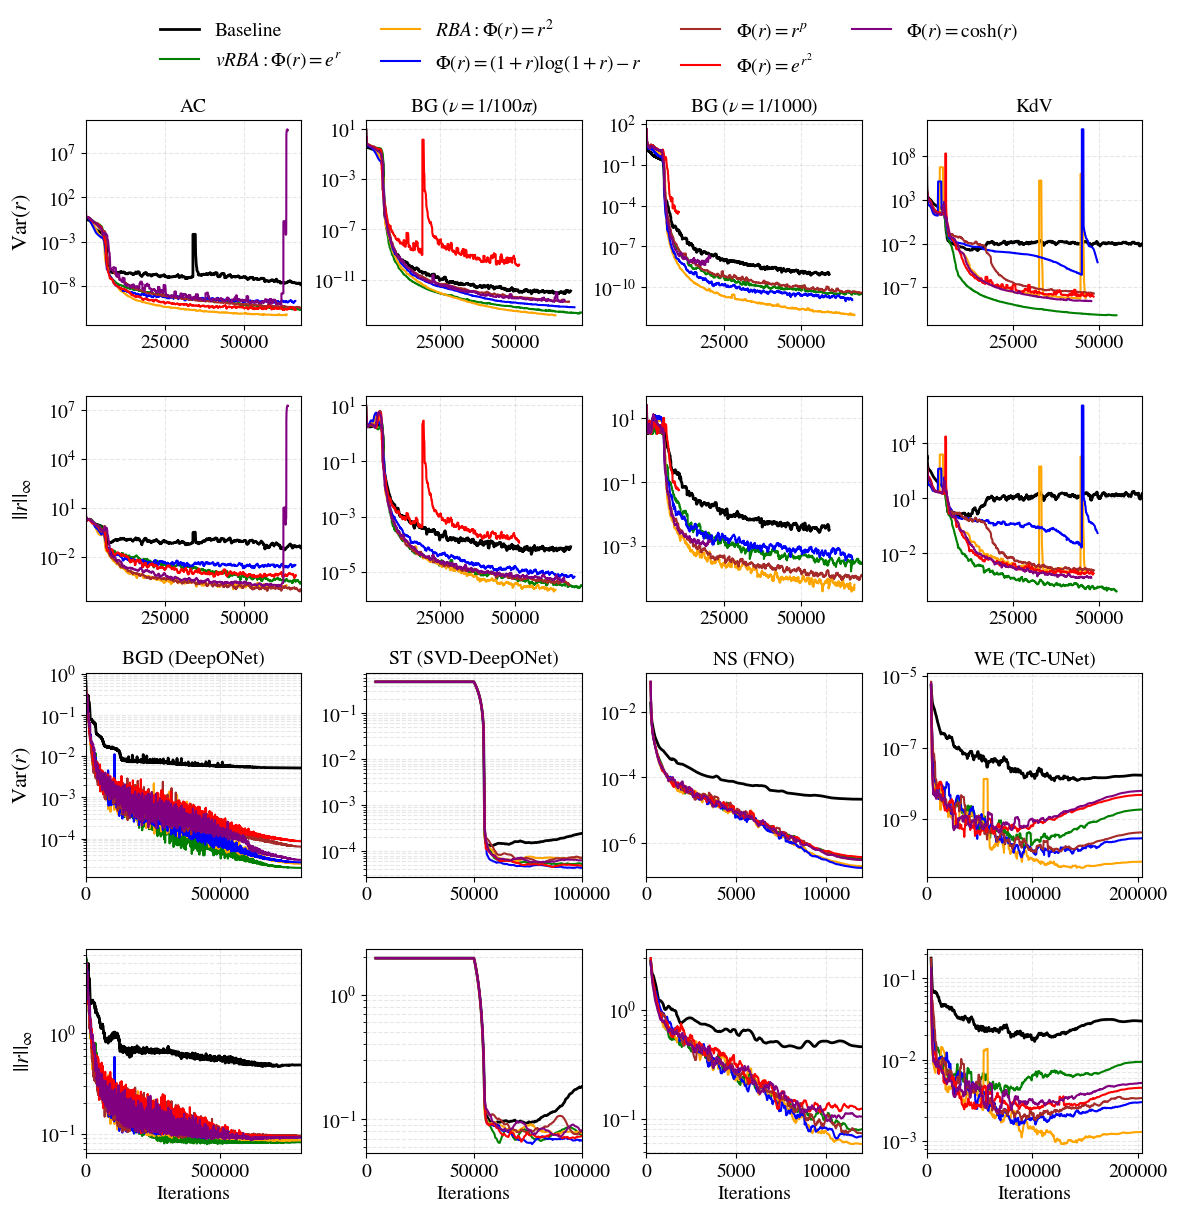

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

# --- 1. Formatting Setup ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- 2. Configuration & Styles ---
EPOCHS_ADAM = 5000  
DIVERGENCE_THRESHOLD = 1e999 
SMOOTHING_WINDOW = 10 

# Batch scalers for Operator Learning
BATCH_SIZE_SCALER_BGD  = 80  
BATCH_SIZE_SCALER_NS   = 24
BATCH_SIZE_SCALER_WAVE = 408 

STYLES = {
    'linear':      {'label': r'Baseline',              'color': 'k'},
    'Vanilla':     {'label': r'Baseline',              'color': 'k'}, 
    'exponential': {'label': r'$vRBA: \Phi(r)=e^{r}$', 'color': 'green'},
    'quadratic':   {'label': r'$RBA: \Phi(r)=r^{2}$',  'color': 'orange'},
    'logarithmic': {'label': r'$\Phi(r)=(1+r)\log(1+r)-r$',   'color': 'blue'},
    'lp':          {'label': r'$\Phi(r)=r^{p}$',       'color': 'brown'},
    'superexp':    {'label': r'$\Phi(r)=e^{r^2}$',     'color': 'red'},
    'cosh':        {'label': r'$\Phi(r)=\cosh(r)$',    'color': 'purple'},
}

# ORDER CHANGE: 'linear' is FIRST, so it plots in the background
METHODS = ['linear', 'exponential', 'quadratic', 'logarithmic', 'lp', 'superexp', 'cosh']

# --- 3. Path Configuration ---
BASE_PINN = '/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/PINN/Potential_analysis'
BASE_OP   = '/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning'

# --- 4. Problem Configurations ---

# PINN
PINN_EXAMPLES = {
    'AC':       {'dir': 'AC',       'file_fmt': 'results_{}.npz',       'name': 'AC'},
    'BG_100pi': {'dir': 'BG_100pi', 'file_fmt': 'burgers_pred_{}.npz',  'name': r'BG ($\nu=1/100\pi$)'},
    'BG_1000':  {'dir': 'BG_1000',  'file_fmt': 'burgers_pred_{}.npz',  'name': r'BG ($\nu=1/1000$)'},
    'KdV':      {'dir': 'KdV',      'file_fmt': 'kdv_results_{}.npz',   'name': 'KdV'},
}
PINN_ORDER = ['AC', 'BG_100pi', 'BG_1000', 'KdV']

# Operator Learning
OP_EXAMPLES = {
    'BGD': {
        'dir': os.path.join(BASE_OP, 'bubble_don/vrba_sample/results'), 
        'name': 'BGD (DeepONet)', 
        'type': 'DeepONet_Generic', 
        'scaler': BATCH_SIZE_SCALER_BGD
    },
    'Sod': {
        'dir': os.path.join(BASE_OP, 'Shocks/HPR'),                      
        'name': 'ST (SVD-DeepONet)',
        'type': 'Sod',      
        'scaler': 1 
    },
    'NS': {
        'dir': os.path.join(BASE_OP, 'ns_fno/vrba_sample/results'),      
        'name': 'NS (FNO)',         
        'type': 'DeepONet_Generic', 
        'scaler': BATCH_SIZE_SCALER_NS
    },
    'Wave': {
        'dir': os.path.join(BASE_OP, 'wave_tcunet/vrba_sample/results'), 
        'name': 'WE (TC-UNet)',      
        'type': 'DeepONet_Generic', 
        'scaler': BATCH_SIZE_SCALER_WAVE
    }
}
OP_ORDER = ['BGD', 'Sod', 'NS', 'Wave']


# --- 5. DATA EXTRACTION LOGIC ---

# 5.1 PINN Helpers
def get_dense_iterations(data, epochs_adam=5000):
    if 'var_hist' not in data or 'all_its' not in data:
        return None
    var_hist = data['var_hist']
    saved_its = data['all_its']
    total_steps = len(var_hist)
    
    if total_steps > epochs_adam:
        iter_adam_dense = np.arange(1, epochs_adam + 1)
        num_ssb_steps = total_steps - epochs_adam
        if num_ssb_steps > 0:
            iter_ssb = saved_its[-num_ssb_steps:]
            return np.concatenate([iter_adam_dense, iter_ssb])
    return np.arange(1, total_steps + 1)

def load_pinn_data(example_key, method):
    ex_config = PINN_EXAMPLES[example_key]
    path = os.path.join(BASE_PINN, ex_config['dir'], ex_config['file_fmt'].format(method))
    
    if not os.path.exists(path): return None, None, None

    try:
        data = np.load(path)
        keys = list(data.keys())
        iter_res, linf, var = None, None, None

        if example_key == 'BG_1000':
            linf = data['linf_hist'] if 'linf_hist' in keys else None
            var  = data['var_hist']  if 'var_hist' in keys else None
            iter_res = get_dense_iterations(data, EPOCHS_ADAM)

        elif example_key == 'KdV':
            linf = data['residual_linf_history'] if 'residual_linf_history' in keys else None
            var  = data['residual_variance_history'] if 'residual_variance_history' in keys else None
            iter_res = data['iterations'] if 'iterations' in keys else None

        else:
            linf = data['linf_history'] if 'linf_history' in keys else (data['linf_hist'] if 'linf_hist' in keys else None)
            var  = data['var_history']  if 'var_history' in keys else (data['var_hist'] if 'var_hist' in keys else None)
            iter_res = data['all_its']  if 'all_its' in keys else None

        target_len = 0
        if var is not None: target_len = len(var)
        elif linf is not None: target_len = len(linf)
        
        if iter_res is None or len(iter_res) != target_len:
            iter_res = np.arange(target_len)

        return iter_res, var, linf

    except Exception as e:
        print(f"Error PINN {example_key}/{method}: {e}")
        return None, None, None

# 5.2 Operator Learning Helpers
def find_metrics_file(base_dir, method_key):
    if not os.path.exists(base_dir): return None
    candidates = glob.glob(os.path.join(base_dir, "metrics_*.npz"))
    search_map = {
        'linear':      ['vanilla', 'uniform', 'baseline', 'linear', 'standard', 'regular'],
        'Vanilla':     ['vanilla', 'uniform', 'baseline', 'standard'],
        'exponential': ['exponential', 'vrba'],
        'quadratic':   ['quadratic', 'rba'],
        'logarithmic': ['log'],
        'lp':          ['lp'],
        'superexp':    ['super'],
        'cosh':        ['cosh']
    }
    targets = search_map.get(method_key, [method_key])
    for filepath in candidates:
        fname = os.path.basename(filepath).lower()
        if method_key == 'quadratic' and 'vrba' in fname: continue
        for t in targets:
            if t in fname: return filepath
    return None

def load_op_data(example_key, method):
    ex_config = OP_EXAMPLES[example_key]
    ex_type = ex_config['type']

    if ex_type == 'DeepONet_Generic':
        filepath = find_metrics_file(ex_config['dir'], method)
        if not filepath: return None, None, None
        try:
            data = np.load(filepath)
            epochs = data['epochs']
            its = epochs * ex_config['scaler']
            var = data['var_residual']
            
            linf = None
            for k in ['L_infty_residual', 'linf', 'val_linf', 'error_linf', 'Linf']:
                if k in data:
                    linf = data[k]
                    break
            return its, var, linf
        except: return None, None, None

    elif ex_type == 'Sod':
        filename = f"results_summary_{method}.npz"
        path = os.path.join(ex_config['dir'], filename)
        if not os.path.exists(path): return None, None, None
        try:
            data = np.load(path)
            linf = data['test_Linf_real']
            var  = data['test_Var_real']
            its = data['iterations'] if 'iterations' in data else np.arange(len(var)) * 100
            return its, var, linf
        except: return None, None, None
    
    return None, None, None

# 5.3 Smoothing Helper
def smooth_curve(y, window_len=SMOOTHING_WINDOW):
    if y is None or len(y) < window_len:
        return y
    box = np.ones(window_len) / window_len
    y_smooth = np.convolve(y, box, mode='valid')
    return y_smooth

# --- 6. Plotting Routine ---
def create_master_plot():
    fig, axes = plt.subplots(4, 4, figsize=(12, 12), sharex=False)
    
    # --- ROW 0: PINN VARIANCE ---
    axes[0, 0].set_ylabel(r'Var$(r)$', fontsize=16)
    for col, ex_key in enumerate(PINN_ORDER):
        ax = axes[0, col]
        ax.set_title(PINN_EXAMPLES[ex_key]['name'], fontsize=14)
        
        max_it = 10
        # Iterate in standard order: 'linear' (index 0) is plotted first -> Background
        for method in METHODS:
            if method not in STYLES: continue
            x, var, _ = load_pinn_data(ex_key, method)
            if x is not None and var is not None:
                var_clean = var.copy()
                var_clean[var_clean > DIVERGENCE_THRESHOLD] = np.nan
                
                if not np.all(np.isnan(var_clean)):
                    y_plot = smooth_curve(var_clean)
                    trim_len = len(x) - len(y_plot)
                    x_plot = x[trim_len:]
                else:
                    x_plot, y_plot = x, var_clean
                
                style = STYLES[method]
                lw = 2.0 if method == 'linear' else 1.5
                ax.plot(x_plot, y_plot, color=style['color'], lw=lw, label=style['label'])
                if len(x_plot) > 0: max_it = max(max_it, x_plot[-1])
        
        ax.set_yscale('log')
        ax.set_xlim(left=10, right=max_it)
        ax.grid(True, which="both", ls="--", alpha=0.3)

    # --- ROW 1: PINN L-INFINITY ---
    axes[1, 0].set_ylabel(r'$||r||_\infty$', fontsize=16)
    for col, ex_key in enumerate(PINN_ORDER):
        ax = axes[1, col]
        max_it = 10
        for method in METHODS:
            if method not in STYLES: continue
            x, _, linf = load_pinn_data(ex_key, method)
            if x is not None and linf is not None:
                linf_clean = linf.copy()
                linf_clean[linf_clean > DIVERGENCE_THRESHOLD] = np.nan
                
                if not np.all(np.isnan(linf_clean)):
                    y_plot = smooth_curve(linf_clean)
                    trim_len = len(x) - len(y_plot)
                    x_plot = x[trim_len:]
                else:
                    x_plot, y_plot = x, linf_clean

                style = STYLES[method]
                lw = 2.0 if method == 'linear' else 1.5
                ax.plot(x_plot, y_plot, color=style['color'], lw=lw)
                if len(x_plot) > 0: max_it = max(max_it, x_plot[-1])
        
        ax.set_yscale('log')
        ax.set_xlim(left=10, right=max_it)
        ax.grid(True, which="both", ls="--", alpha=0.3)

    # --- ROW 2: OPERATOR VARIANCE ---
    axes[2, 0].set_ylabel(r'Var$(r)$', fontsize=16)
    for col, ex_key in enumerate(OP_ORDER):
        ax = axes[2, col]
        ax.set_title(OP_EXAMPLES[ex_key]['name'], fontsize=14)
        
        max_it = 10
        for method in METHODS:
            if method not in STYLES: continue
            style_key = method
            if method == 'linear' and 'Vanilla' in STYLES: style_key = 'linear'
            
            x, var, _ = load_op_data(ex_key, method)
            if x is not None and var is not None:
                var_clean = var.copy()
                var_clean[var_clean > DIVERGENCE_THRESHOLD] = np.nan

                if not np.all(np.isnan(var_clean)):
                    y_plot = smooth_curve(var_clean)
                    trim_len = len(x) - len(y_plot)
                    x_plot = x[trim_len:]
                else:
                    x_plot, y_plot = x, var_clean

                style = STYLES[style_key]
                lw = 2.0 if method == 'linear' else 1.5
                ax.plot(x_plot, y_plot, color=style['color'], lw=lw)
                if len(x_plot) > 0: max_it = max(max_it, x_plot[-1])

        ax.set_yscale('log')
        ax.set_xlim(left=0, right=max_it)
        ax.grid(True, which="both", ls="--", alpha=0.3)

    # --- ROW 3: OPERATOR L-INFINITY ---
    axes[3, 0].set_ylabel(r'$||r||_\infty$', fontsize=16)
    for col, ex_key in enumerate(OP_ORDER):
        ax = axes[3, col]
        max_it = 10
        for method in METHODS:
            if method not in STYLES: continue
            style_key = method
            if method == 'linear' and 'Vanilla' in STYLES: style_key = 'linear'
            
            x, _, linf = load_op_data(ex_key, method)
            if x is not None and linf is not None:
                linf_clean = linf.copy()
                linf_clean[linf_clean > DIVERGENCE_THRESHOLD] = np.nan
                
                if not np.all(np.isnan(linf_clean)):
                    y_plot = smooth_curve(linf_clean)
                    trim_len = len(x) - len(y_plot)
                    x_plot = x[trim_len:]
                else:
                    x_plot, y_plot = x, linf_clean

                style = STYLES[style_key]
                lw = 2.0 if method == 'linear' else 1.5
                ax.plot(x_plot, y_plot, color=style['color'], lw=lw)
                if len(x_plot) > 0: max_it = max(max_it, x_plot[-1])

        ax.set_yscale('log')
        ax.set_xlim(left=0, right=max_it)
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.set_xlabel('Iterations', fontsize=14)

    # --- LEGEND ---
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
               ncol=4, frameon=False, fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.35, wspace=0.3)
    
    plt.savefig('Var_Linfty.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    create_master_plot()

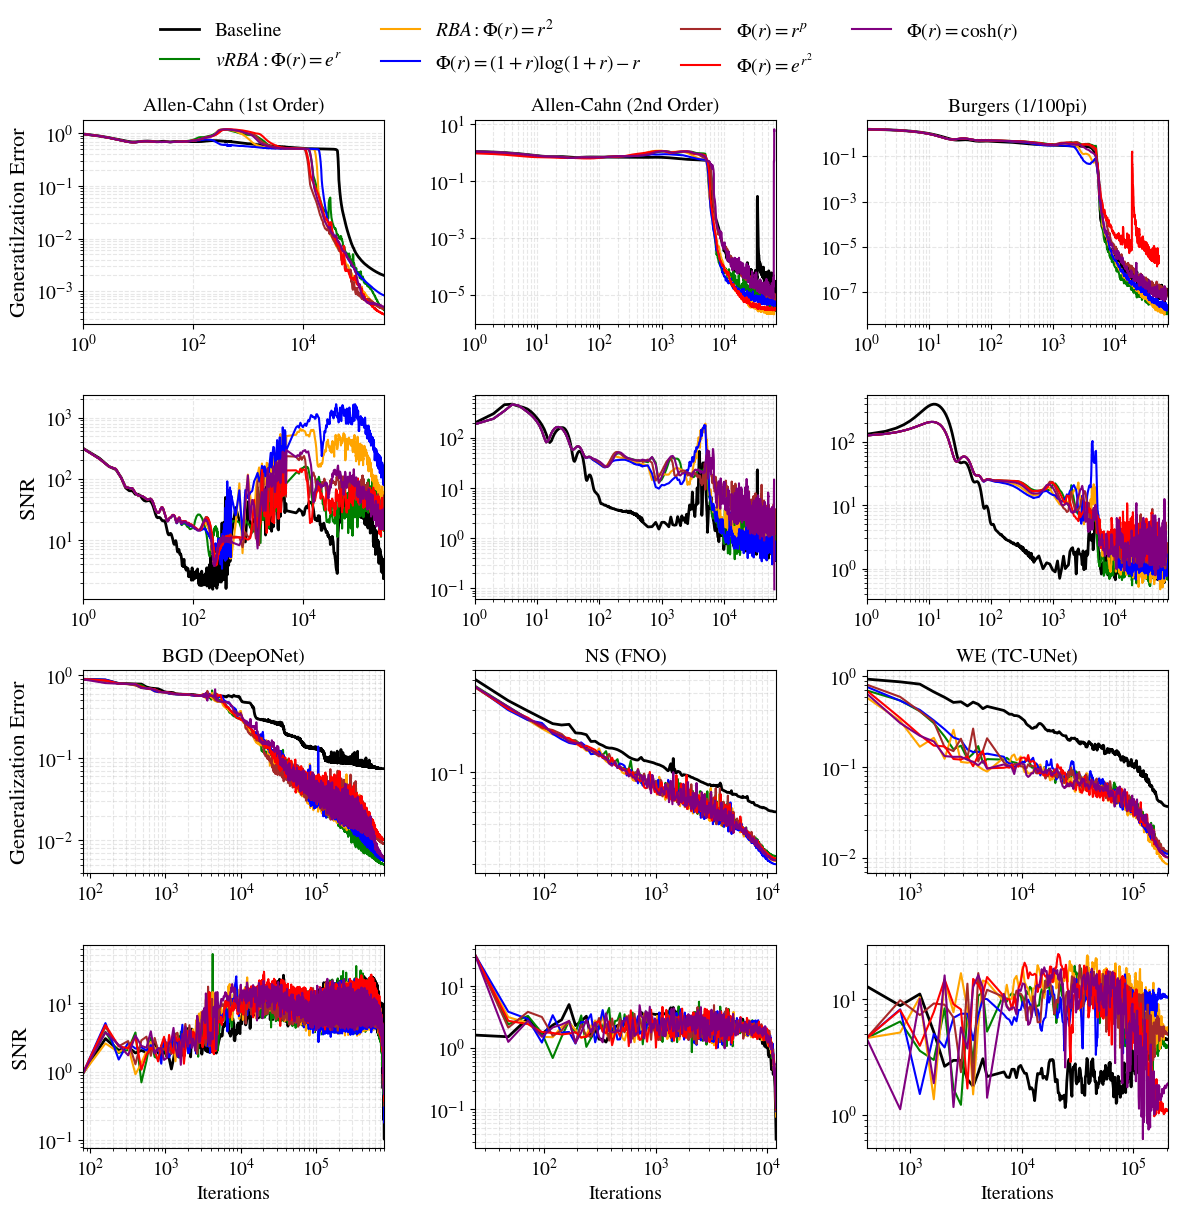

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import glob

# --- 1. Formatting Setup ---
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['font.size'] = 14

# --- 2. Configuration & Styles ---
EPOCHS_ADAM = 5000  
DIVERGENCE_THRESHOLD = 1e999 
SMOOTHING_WINDOW = 5 
TRANSITION_POINT = 5000 # Stop smoothing before this iteration

# Batch scalers for Operator Learning
BATCH_SIZE_SCALER_BGD  = 80  
BATCH_SIZE_SCALER_NS   = 24
BATCH_SIZE_SCALER_WAVE = 408 

STYLES = {
    'linear':      {'label': r'Baseline',              'color': 'k'},
    'Vanilla':     {'label': r'Baseline',              'color': 'k'}, 
    'exponential': {'label': r'$vRBA: \Phi(r)=e^{r}$', 'color': 'green'},
    'quadratic':   {'label': r'$RBA: \Phi(r)=r^{2}$',  'color': 'orange'},
    'logarithmic': {'label': r'$\Phi(r)=(1+r)\log(1+r)-r$',   'color': 'blue'},
    'lp':          {'label': r'$\Phi(r)=r^{p}$',       'color': 'brown'},
    'superexp':    {'label': r'$\Phi(r)=e^{r^2}$',     'color': 'red'},
    'cosh':        {'label': r'$\Phi(r)=\cosh(r)$',    'color': 'purple'},
}

# Linear first -> Background
METHODS = ['linear', 'exponential', 'quadratic', 'logarithmic', 'lp', 'superexp', 'cosh']

# --- 3. Path Configuration ---
BASE_PINN = '/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/PINN/Potential_analysis'
BASE_OP   = '/users/jdtoscan/data/jdtoscan/References/Variational-Residual-Based-Attention-vRBA-for-PINNs-and-Operator-Networks-/Operator_Learning'

# --- 4. Problem Configurations ---
PINN_EXAMPLES = {
    'AC_1st_order': {'dir': 'AC_1st_order', 'file_fmt': 'results_{}.npz',       'name': 'Allen-Cahn (1st Order)'},
    'AC':           {'dir': 'AC',           'file_fmt': 'results_{}.npz',       'name': 'Allen-Cahn (2nd Order)'},
    'BG_100pi':     {'dir': 'BG_100pi',     'file_fmt': 'burgers_pred_{}.npz',  'name': r'Burgers (1/100pi)'},
}
PINN_ORDER = ['AC_1st_order', 'AC', 'BG_100pi']

OP_EXAMPLES = {
    'BGD': {
        'dir': os.path.join(BASE_OP, 'bubble_don/vrba_sample/results'), 
        'name': 'BGD (DeepONet)', 
        'type': 'DeepONet_Generic', 
        'scaler': BATCH_SIZE_SCALER_BGD
    },
    'NS': {
        'dir': os.path.join(BASE_OP, 'ns_fno/vrba_sample/results'),      
        'name': 'NS (FNO)',         
        'type': 'DeepONet_Generic', 
        'scaler': BATCH_SIZE_SCALER_NS
    },
    'Wave': {
        'dir': os.path.join(BASE_OP, 'wave_tcunet/vrba_sample/results'), 
        'name': 'WE (TC-UNet)',      
        'type': 'DeepONet_Generic', 
        'scaler': BATCH_SIZE_SCALER_WAVE
    }
}
OP_ORDER = ['BGD', 'NS', 'Wave']


# --- 5. Data Extraction ---
def get_dense_iterations(data, epochs_adam=5000):
    if 'error_history' not in data and 'loss_history' not in data: return None
    ref_len = 0
    if 'error_history' in data: ref_len = len(data['error_history'])
    elif 'loss_history' in data: ref_len = len(data['loss_history'])
    if ref_len == 0: return None
    
    saved_its = data['all_its'] if 'all_its' in data else None
    if saved_its is not None and len(saved_its) == ref_len:
        return saved_its
    if ref_len > epochs_adam and saved_its is not None:
        iter_adam_dense = np.arange(1, epochs_adam + 1)
        num_ssb_steps = ref_len - epochs_adam
        if num_ssb_steps > 0:
            iter_ssb = saved_its[-num_ssb_steps:]
            return np.concatenate([iter_adam_dense, iter_ssb])
    return np.arange(1, ref_len + 1)

def load_pinn_data(example_key, method):
    ex_config = PINN_EXAMPLES[example_key]
    path = os.path.join(BASE_PINN, ex_config['dir'], ex_config['file_fmt'].format(method))
    if not os.path.exists(path): return None, None, None

    try:
        data = np.load(path)
        l2  = data['error_history'] if 'error_history' in data else None
        snr = data['snr_history']   if 'snr_history' in data else None
        iter_res = get_dense_iterations(data, EPOCHS_ADAM)
        
        target_len = 0
        if l2 is not None: target_len = len(l2)
        elif snr is not None: target_len = len(snr)
        
        if iter_res is None or len(iter_res) != target_len:
             iter_res = np.arange(target_len)
             
        if l2 is not None and len(l2) > len(iter_res): l2 = l2[:len(iter_res)]
        if snr is not None and len(snr) > len(iter_res): snr = snr[:len(iter_res)]

        return iter_res, l2, snr
    except Exception as e:
        print(f"Error PINN {example_key}/{method}: {e}")
        return None, None, None

def find_metrics_file(base_dir, method_key):
    if not os.path.exists(base_dir): return None
    candidates = glob.glob(os.path.join(base_dir, "metrics_*.npz"))
    search_map = {
        'linear':      ['vanilla', 'uniform', 'baseline', 'linear', 'standard', 'regular'],
        'Vanilla':     ['vanilla', 'uniform', 'baseline', 'standard'],
        'exponential': ['exponential', 'vrba'],
        'quadratic':   ['quadratic', 'rba'],
        'logarithmic': ['log'],
        'lp':          ['lp'],
        'superexp':    ['super'],
        'cosh':        ['cosh']
    }
    targets = search_map.get(method_key, [method_key])
    for filepath in candidates:
        fname = os.path.basename(filepath).lower()
        if method_key == 'quadratic' and 'vrba' in fname: continue
        for t in targets:
            if t in fname: return filepath
    return None

def load_op_data(example_key, method):
    ex_config = OP_EXAMPLES[example_key]
    filepath = find_metrics_file(ex_config['dir'], method)
    if not filepath: return None, None, None
    try:
        data = np.load(filepath)
        epochs = data['epochs']
        its = epochs * ex_config['scaler']
        l2  = data['val_loss']
        snr = data['snr']
        return its, l2, snr
    except: return None, None, None

# --- 6. Hybrid Smoothing Logic ---
def get_hybrid_curve(x, y, transition=TRANSITION_POINT, window=SMOOTHING_WINDOW):
    """
    Returns x_plot, y_plot where:
      - For x <= transition: Data is RAW (unsmoothed)
      - For x > transition: Data is SMOOTHED
      - Arrays are concatenated to ensure continuity.
    """
    if y is None or len(y) == 0: return None, None
    
    # Clean Divergence first
    y_clean = y.copy()
    y_clean[y_clean > DIVERGENCE_THRESHOLD] = np.nan
    
    # Split indices
    mask_early = x <= transition
    mask_late  = x > transition
    
    x_early = x[mask_early]
    y_early = y_clean[mask_early]
    
    x_late = x[mask_late]
    y_late = y_clean[mask_late]
    
    # Process Late part
    if len(y_late) >= window:
        box = np.ones(window) / window
        y_late_smooth = np.convolve(y_late, box, mode='valid')
        # Align x_late (trim start)
        trim_len = len(x_late) - len(y_late_smooth)
        x_late_smooth = x_late[trim_len:]
    else:
        # Not enough points to smooth, keep raw
        x_late_smooth = x_late
        y_late_smooth = y_late
        
    # Concatenate to form single line
    x_final = np.concatenate([x_early, x_late_smooth])
    y_final = np.concatenate([y_early, y_late_smooth])
    
    return x_final, y_final

# --- 7. Plotting ---
def create_snr_comparison():
    fig, axes = plt.subplots(4, 3, figsize=(12, 12), sharex=False)
    
    # --- ROW 1: PINN L2 ---
    axes[0, 0].set_ylabel(r'Generatilzation Error', fontsize=16)
    for col, ex_key in enumerate(PINN_ORDER):
        ax = axes[0, col]
        ax.set_title(PINN_EXAMPLES[ex_key]['name'], fontsize=14)
        
        for method in METHODS:
            if method not in STYLES: continue
            x, l2, _ = load_pinn_data(ex_key, method)
            
            if x is not None and l2 is not None:
                x_plot, y_plot = get_hybrid_curve(x, l2)
                
                style = STYLES[method]
                lw = 2.0 if method == 'linear' else 1.5
                ax.plot(x_plot, y_plot, color=style['color'], lw=lw, label=style['label'])

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.3)
        # Adapt X-Axis (no forced left limit)
        ax.autoscale(enable=True, axis='x', tight=True)

    # --- ROW 2: PINN SNR ---
    axes[1, 0].set_ylabel(r'SNR', fontsize=16)
    for col, ex_key in enumerate(PINN_ORDER):
        ax = axes[1, col]
        
        for method in METHODS:
            if method not in STYLES: continue
            x, _, snr = load_pinn_data(ex_key, method)
            
            if x is not None and snr is not None:
                x_plot, y_plot = get_hybrid_curve(x, snr)

                style = STYLES[method]
                lw = 2.0 if method == 'linear' else 1.5
                ax.plot(x_plot, y_plot, color=style['color'], lw=lw)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.autoscale(enable=True, axis='x', tight=True)

    # --- ROW 3: OP L2 ---
    axes[2, 0].set_ylabel(r'Generalization Error', fontsize=16)
    for col, ex_key in enumerate(OP_ORDER):
        ax = axes[2, col]
        ax.set_title(OP_EXAMPLES[ex_key]['name'], fontsize=14)
        
        for method in METHODS:
            if method not in STYLES: continue
            style_key = method
            if method == 'linear' and 'Vanilla' in STYLES: style_key = 'linear'
            
            x, l2, _ = load_op_data(ex_key, method)
            
            if x is not None and l2 is not None:
                x_plot, y_plot = get_hybrid_curve(x, l2)

                style = STYLES[style_key]
                lw = 2.0 if method == 'linear' else 1.5
                ax.plot(x_plot, y_plot, color=style['color'], lw=lw)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.autoscale(enable=True, axis='x', tight=True)

    # --- ROW 4: OP SNR ---
    axes[3, 0].set_ylabel(r'SNR', fontsize=16)
    for col, ex_key in enumerate(OP_ORDER):
        ax = axes[3, col]
        
        for method in METHODS:
            if method not in STYLES: continue
            style_key = method
            if method == 'linear' and 'Vanilla' in STYLES: style_key = 'linear'
            
            x, _, snr = load_op_data(ex_key, method)
            
            if x is not None and snr is not None:
                x_plot, y_plot = get_hybrid_curve(x, snr)

                style = STYLES[style_key]
                lw = 2.0 if method == 'linear' else 1.5
                ax.plot(x_plot, y_plot, color=style['color'], lw=lw)

        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.grid(True, which="both", ls="--", alpha=0.3)
        ax.set_xlabel('Iterations', fontsize=14)
        ax.autoscale(enable=True, axis='x', tight=True)

    # --- LEGEND ---
    handles, labels = axes[0, 0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
               ncol=4, frameon=False, fontsize=14)

    plt.tight_layout()
    plt.subplots_adjust(top=0.92, hspace=0.35, wspace=0.3)
    
    plt.savefig('Master_SNR_HybridSmooth.png', dpi=300, bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    create_snr_comparison()